# Artificial Neural Networks and Deep Learning

---

## Homework 2: Bio.log(y)

### Model 2: Residual U-Net + Attention Gates

In [1]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np
import pandas as pd

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.saving import register_keras_serializable


# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 2


## ⏳ Load the Data

In [2]:
# Load the compressed dataset
data = np.load("/kaggle/input/mydatasets-base/mars_datasets_base.npz")

# Extract the individual arrays
X_train = data["X_train"]
y_train = data["y_train"]
X_val = data["X_val"]
y_val = data["y_val"]
X_our_test = data["X_our_test"]
y_our_test = data["y_our_test"]
X_test = data["X_test"]

# Print shapes to verify successful loading
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_our_test shape: {X_our_test.shape}")
print(f"y_our_test shape: {y_our_test.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (1503, 64, 128, 1)
y_train shape: (1503, 64, 128)
X_val shape: (501, 64, 128, 1)
y_val shape: (501, 64, 128)
X_our_test shape: (501, 64, 128, 1)
y_our_test shape: (501, 64, 128)
X_test shape: (10022, 64, 128, 1)


## 🛠️ Train and Save the Model

In [3]:
input_shape = (64, 128, 1)
num_classes = len(np.unique(y_train))

In [4]:
# Number of training epochs
epochs = 200

# Batch size for training
batch_size = 32

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)

Epochs: 200
Batch Size: 32


In [5]:
def create_segmentation_colormap(num_classes):
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    label = np.asarray(label).squeeze()

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

In [6]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image, label, num_classes, frequency=5):
        super().__init__()
        self.image = image
        self.label = label  # Assumiamo che `label` sia già un array NumPy
        self.num_classes = num_classes
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualizza solo ogni "frequency" epoche
            pred = self.model.predict(tf.expand_dims(self.image, axis=0), verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1).numpy()

            # Create colormap
            colormap = create_segmentation_colormap(self.num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(self.image.squeeze(), cmap='gray')
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(self.label, colormap)  # Rimosso `.numpy()`
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

In [7]:
def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):

    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])

    # Exclude the background class
    y_true = y_true[..., 1:]
    y_pred = y_pred[..., 1:]

    # Clip predictions
    epsilon = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)

    # Focal loss
    cross_entropy = -y_true * tf.math.log(y_pred)
    weights = alpha * tf.math.pow(1 - y_pred, gamma)
    loss = weights * cross_entropy
    return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))

def dice_loss(y_true, y_pred, smooth=1e-6):

    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=5)

    # Exclude the background class
    y_true = y_true[..., 1:]
    y_pred = y_pred[..., 1:]

    # Intersection and union
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2])

    # Dice loss
    dice = 1 - (2. * intersection + smooth) / (union + smooth)
    return tf.reduce_mean(dice)

def combined_loss(y_true, y_pred, dice_weight=0.5, focal_weight=0.5):
    d_loss = dice_loss(y_true, y_pred)
    f_loss = focal_loss(y_true, y_pred)
    return focal_weight * f_loss + dice_weight * d_loss

In [8]:
def residual_block(x, filters, kernel_size=3, activation='relu', name=''):
    """A residual block with two convolutions, batch norm, and a skip connection."""
    skip = x
    # First conv
    x = tfkl.Conv2D(filters, kernel_size, padding='same', name=name+'conv1')(x)
    x = tfkl.BatchNormalization(name=name+'bn1')(x)
    x = tfkl.Activation(activation, name=name+'act1')(x)

    # Second conv
    x = tfkl.Conv2D(filters, kernel_size, padding='same', name=name+'conv2')(x)
    x = tfkl.BatchNormalization(name=name+'bn2')(x)

    # Adjust skip if necessary
    if skip.shape[-1] != filters:
        skip = tfkl.Conv2D(filters, 1, padding='same', name=name+'conv_skip')(skip)

    x = tfkl.Add(name=name+'add')([x, skip])
    x = tfkl.Activation(activation, name=name+'act2')(x)
    return x

In [9]:
def stacked_residual_blocks(input_tensor, filters, stack=1, kernel_size=3, activation='relu', name=''):
    """
    Apply a stack of residual blocks with a specified number of repetitions (stack).
    """
    x = input_tensor
    for i in range(stack):
        x = residual_block(x, filters, kernel_size=kernel_size, activation=activation, name=name + f'stack{i+1}_')
    return x

In [10]:
def attention_gate(x, g, filters, name=''):
    """An attention gate that highlights relevant features from the skip connection x
    using the gating signal g from the decoder."""
    # Project x and g into a common space
    x_in = tfkl.Conv2D(filters, 1, padding='same', name=name+'x_conv')(x)
    g_in = tfkl.Conv2D(filters, 1, padding='same', name=name+'g_conv')(g)

    attn = tfkl.Activation('relu', name=name+'attn_relu')(tfkl.Add(name=name+'add')([x_in, g_in]))
    attn = tfkl.Conv2D(1, 1, padding='same', name=name+'attn_conv')(attn)
    attn = tfkl.Activation('sigmoid', name=name+'attn_sigmoid')(attn)

    x = tfkl.Multiply(name=name+'attn_mul')([x, attn])
    return x

In [11]:
def get_improved_unet_model(input_shape=(64,128,1), num_classes=5, activation='relu', stacks=[1, 2, 3, 2]):
    """
    Builds an improved U-Net model with residual blocks and attention gates.
    Encoder-Decoder structure:
      - Encoder: 3 levels of downsampling with residual blocks
      - Bottleneck: 1 residual block
      - Decoder: 3 levels of upsampling with attention gates on skip connections
    You can adjust the number of filters per level as needed.
    """
    inputs = tfkl.Input(shape=input_shape, name='input_layer')

    # Encoder
    f1 = stacked_residual_blocks(inputs, 64, stack=stacks[0], name='enc1_')  # Level 1
    p1 = tfkl.MaxPooling2D((2,2), name='pool1')(f1)

    f2 = stacked_residual_blocks(p1, 128, stack=stacks[1], name='enc2_')  # Level 2
    p2 = tfkl.MaxPooling2D((2,2), name='pool2')(f2)

    f3 = stacked_residual_blocks(p2, 256, stack=stacks[2], name='enc3_')  # Level 3
    p3 = tfkl.MaxPooling2D((2,2), name='pool3')(f3)

    # Bottleneck
    bottleneck = stacked_residual_blocks(p3, 512, stack=stacks[3], name='bottleneck_')

    # Decoder
    u1 = tfkl.UpSampling2D((2,2), name='up1')(bottleneck)
    attn3 = attention_gate(f3, u1, filters=256, name='attn3_')
    u1 = tfkl.Concatenate(name='concat3')([u1, attn3])
    u1 = stacked_residual_blocks(u1, 256, stack=stacks[2], name='dec3_')

    u2 = tfkl.UpSampling2D((2,2), name='up2')(u1)
    attn2 = attention_gate(f2, u2, filters=128, name='attn2_')
    u2 = tfkl.Concatenate(name='concat2')([u2, attn2])
    u2 = stacked_residual_blocks(u2, 128, stack=stacks[1], name='dec2_')

    u3 = tfkl.UpSampling2D((2,2), name='up3')(u2)
    attn1 = attention_gate(f1, u3, filters=64, name='attn1_')
    u3 = tfkl.Concatenate(name='concat1')([u3, attn1])
    u3 = stacked_residual_blocks(u3, 64, stack=stacks[0], name='dec1_')

    # Output layer
    outputs = tfkl.Conv2D(num_classes, (1,1), activation='softmax', name='output_layer')(u3)

    model = tf.keras.Model(inputs, outputs, name='Improved_UNet')
    return model

Model: "Improved_UNet"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_stack1_conv1 │ (None, 64, 128, │       640 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_stack1_bn1   │ (None, 64, 128, │       256 │ enc1_stack1_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_stack1_act1  │ (None, 64, 128, │         0 │ enc1_stack1_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_stack1_conv2 │ (None, 64, 128, │    36,928 │ enc1_stack1_a… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_stack1_bn2   │ (None, 64, 128, │       256 │ enc1_stack1_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_stack1_conv… │ (None, 64, 128, │       128 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_stack1_add   │ (None, 64, 128, │         0 │ enc1_stack1_b… │   -   │
│ (Add)             │ 64)             │           │ enc1_stack1_c… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_stack1_act2  │ (None, 64, 128, │         0 │ enc1_stack1_a… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ pool1             │ (None, 32, 64,  │         0 │ enc1_stack1_a… │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc2_stack1_conv1 │ (None, 32, 64,  │    73,856 │ pool1[0][0]    │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc2_stack1_bn1   │ (None, 32, 64,  │       512 │ enc2_stack1_c… │   Y   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc2_stack1_act1  │ (None, 32, 64,  │         0 │ enc2_stack1_b… │   -   │
│ (Activation)      │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc2_stack1_conv2 │ (None, 32, 64,  │   147,584 │ enc2_stack1_a… │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc2_stack1_bn2   │ (None, 32, 64,  │       512 │ enc2_stack1_c… │   Y   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc2_stack1_conv… │ (None, 32, 64,  │     8,320 │ pool1[0][0]    │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc2_stack1_add   │ (None, 32, 64,  │         0 │ enc2_stack1_b… │   - 

 Total params: 18,529,160 (70.68 MB)

 Trainable params: 18,516,360 (70.63 MB)

 Non-trainable params: 12,800 (50.00 KB)

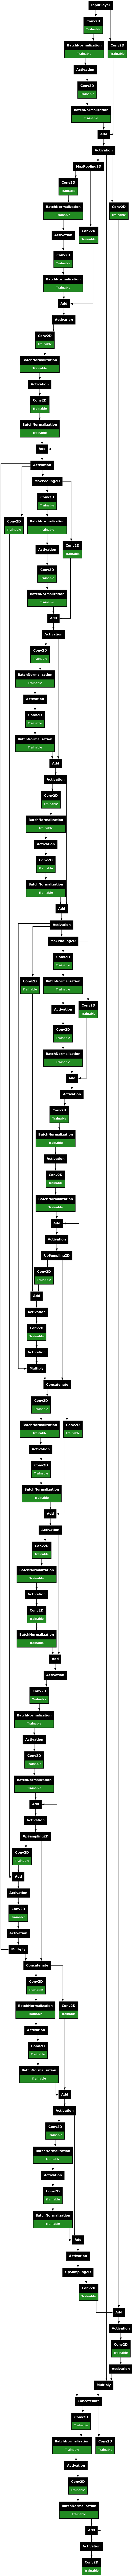

In [12]:
model = get_improved_unet_model()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [13]:
model.compile(optimizer="adam",
              loss=lambda y_true, y_pred: combined_loss(y_true, y_pred, dice_weight=0.2, focal_weight=0.8),
              metrics=["accuracy",
                       MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])])

model.summary()

Model: "Improved_UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 128,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_stack1_conv1   │ (None, 64, 128,   │        640 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_stack1_bn1     │ (None, 64, 128,   │        256 │ enc1_stack1_conv… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_stack1_act1    │ (None, 64, 128,   │          0 │ enc1_stack1_bn1[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_stack1_conv2   │ (None, 64, 128,   │     36,928 │ enc1_stack1_act1… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_stack1_bn2     │ (None, 64, 128,   │        256 │ enc1_stack1_conv… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_stack1_conv_s… │ (None, 64, 128,   │        128 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_stack1_add     │ (None, 64, 128,   │          0 │ enc1_stack1_bn2[… │
│ (Add)               │ 64)               │            │ enc1_stack1_conv… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_stack1_act2    │ (None, 64, 128,   │          0 │ enc1_stack1_add[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 32, 64,    │          0 │ enc1_stack1_act2… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc2_stack1_conv1   │ (None, 32, 64,    │     73,856 │ pool1[0][0]       │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc2_stack1_bn1     │ (None, 32, 64,    │        512 │ enc2_stack1_conv… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc2_stack1_act1    │ (None, 32, 64,    │          0 │ enc2_stack1_bn1[… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc2_stack1_conv2   │ (None, 32, 64,    │    147,584 │ enc2_stack1_act1… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc2_stack1_bn2     │ (None, 32, 64,    │        512 │ enc2_stack1_conv… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc2_stack1_conv_s… │ (None, 32, 64,    │      8,320 │ pool1[0][0]       │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc2_stack1_add     │ (None, 32, 64,    │          0 │ enc2_stack1_bn2[

 Total params: 18,529,160 (70.68 MB)

 Trainable params: 18,516,360 (70.63 MB)

 Non-trainable params: 12,800 (50.00 KB)

In [14]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=20,
    restore_best_weights=True
)

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

# Select a specific image and mask from the dataset
sample_idx = 42
sample_image = X_train[sample_idx]
sample_mask = y_train[sample_idx]

# Initialize the VizCallback with the selected image and mask
viz_callback = VizCallback(
    image=sample_image,
    label=sample_mask,
    num_classes=num_classes,
    frequency=5
)

Epoch 1/200


I0000 00:00:1734183939.240444      92 service.cc:145] XLA service 0x7bc3b0001f30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734183939.240495      92 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734183939.240499      92 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1734183981.015256      92 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_9', 16 bytes spill stores, 16 bytes spill loads

I0000 00:00:1734183981.048414      92 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.3267 - loss: 0.3221 - mean_iou: 0.1617

I0000 00:00:1734184039.220872      92 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_9', 16 bytes spill stores, 16 bytes spill loads



47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3277 - loss: 0.3208 - mean_iou: 0.1624   

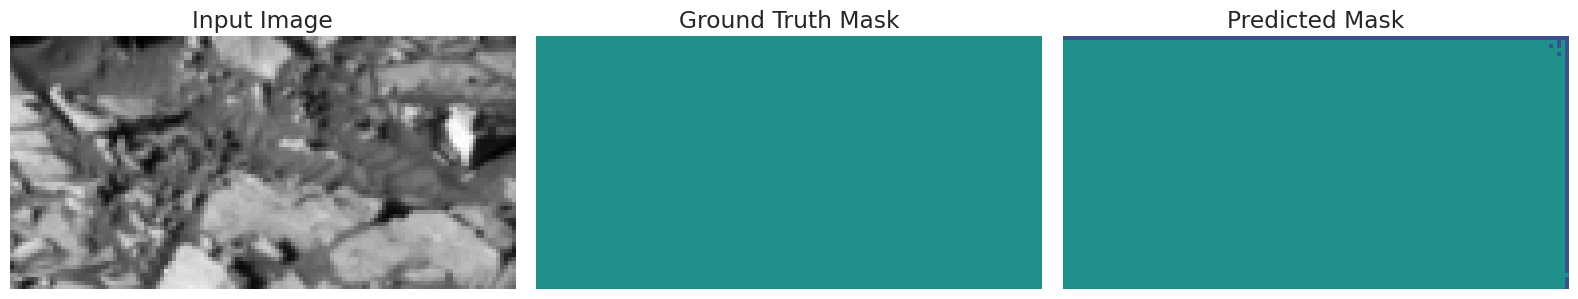

47/47 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.3287 - loss: 0.3195 - mean_iou: 0.1631 - val_accuracy: 0.2391 - val_loss: 1.8181 - val_mean_iou: 0.0826 - learning_rate: 0.0010
Epoch 2/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 412ms/step - accuracy: 0.3831 - loss: 0.2287 - mean_iou: 0.2599 - val_accuracy: 0.2353 - val_loss: 1.6403 - val_mean_iou: 0.0844 - learning_rate: 0.0010
Epoch 3/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 424ms/step - accuracy: 0.4430 - loss: 0.2193 - mean_iou: 0.3149 - val_accuracy: 0.1830 - val_loss: 0.3695 - val_mean_iou: 0.0601 - learning_rate: 0.0010
Epoch 4/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 439ms/step - accuracy: 0.4986 - loss: 0.2127 - mean_iou: 0.3759 - val_accuracy: 0.1830 - val_loss: 0.4618 - val_mean_iou: 0.0601 - learning_rate: 0.0010
Epoch 5/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 429ms/step - accuracy: 0.5369 - loss: 0.2071 - mean_iou: 0.4213 - val_accuracy: 0.1830 - val_loss: 0.4248 - val_mean_iou: 0.0601 - learning_rate: 0.0010
Epoch 6/200
47/47 ━━━━━━━━━━━━━━━━

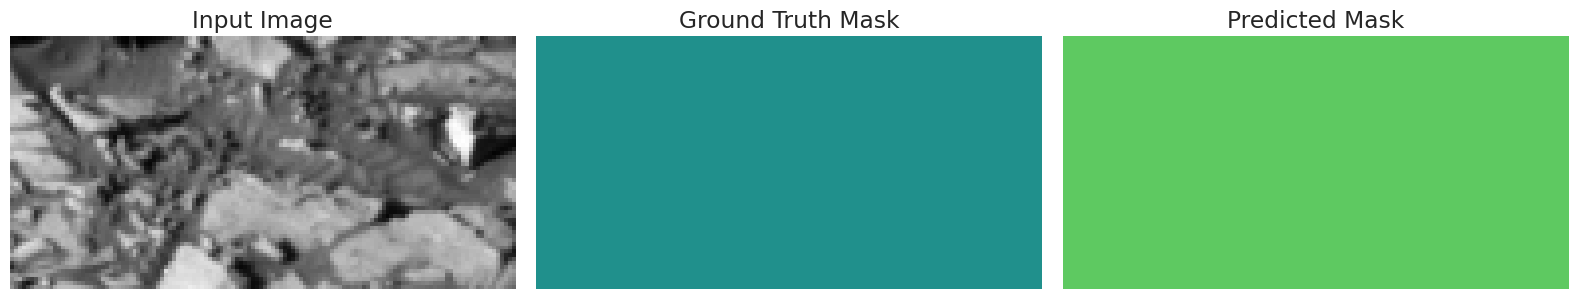

47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 432ms/step - accuracy: 0.5678 - loss: 0.1995 - mean_iou: 0.4574 - val_accuracy: 0.1830 - val_loss: 0.4856 - val_mean_iou: 0.0601 - learning_rate: 0.0010
Epoch 7/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 424ms/step - accuracy: 0.5948 - loss: 0.1962 - mean_iou: 0.4941 - val_accuracy: 0.1834 - val_loss: 0.4552 - val_mean_iou: 0.0604 - learning_rate: 0.0010
Epoch 8/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.6036 - loss: 0.1928 - mean_iou: 0.5068
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 431ms/step - accuracy: 0.6036 - loss: 0.1929 - mean_iou: 0.5066 - val_accuracy: 0.1831 - val_loss: 0.5735 - val_mean_iou: 0.0602 - learning_rate: 0.0010
Epoch 9/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 426ms/step - accuracy: 0.6138 - loss: 0.1907 - mean_iou: 0.5206 - val_accuracy: 0.2116 - val_loss: 0.5286 - val_mean_iou: 0.0839 - learning_rate: 5.0000e-04
Epoch 10/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 427ms/step

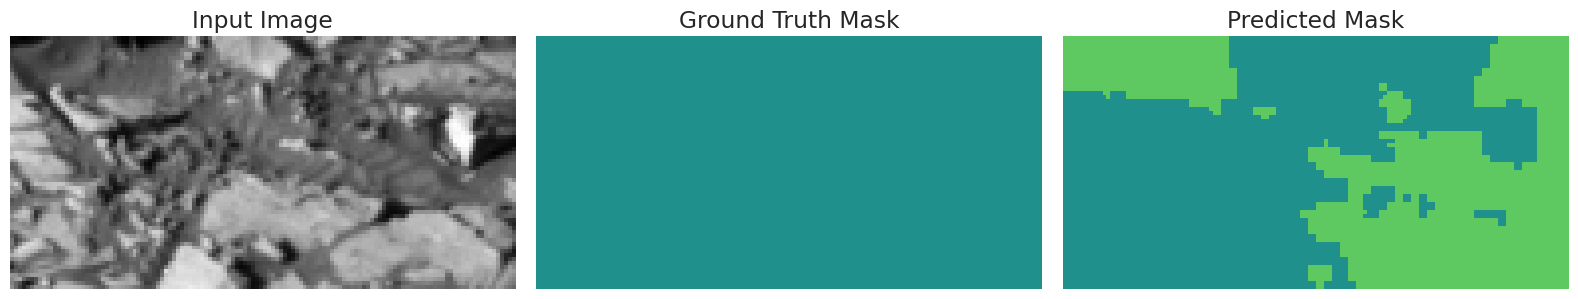

47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 443ms/step - accuracy: 0.6229 - loss: 0.1872 - mean_iou: 0.5350 - val_accuracy: 0.3217 - val_loss: 0.3715 - val_mean_iou: 0.1832 - learning_rate: 5.0000e-04
Epoch 12/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 433ms/step - accuracy: 0.6366 - loss: 0.1839 - mean_iou: 0.5560 - val_accuracy: 0.4707 - val_loss: 0.2786 - val_mean_iou: 0.3214 - learning_rate: 5.0000e-04
Epoch 13/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 429ms/step - accuracy: 0.6301 - loss: 0.1839 - mean_iou: 0.5452 - val_accuracy: 0.4352 - val_loss: 0.3078 - val_mean_iou: 0.3006 - learning_rate: 5.0000e-04
Epoch 14/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 428ms/step - accuracy: 0.6373 - loss: 0.1829 - mean_iou: 0.5616 - val_accuracy: 0.4842 - val_loss: 0.2702 - val_mean_iou: 0.3532 - learning_rate: 5.0000e-04
Epoch 15/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 428ms/step - accuracy: 0.6388 - loss: 0.1818 - mean_iou: 0.5630 - val_accuracy: 0.4816 - val_loss: 0.2336 - val_mean_iou: 0.3616 - learning_rate: 5.0000e-04
Epoch 16

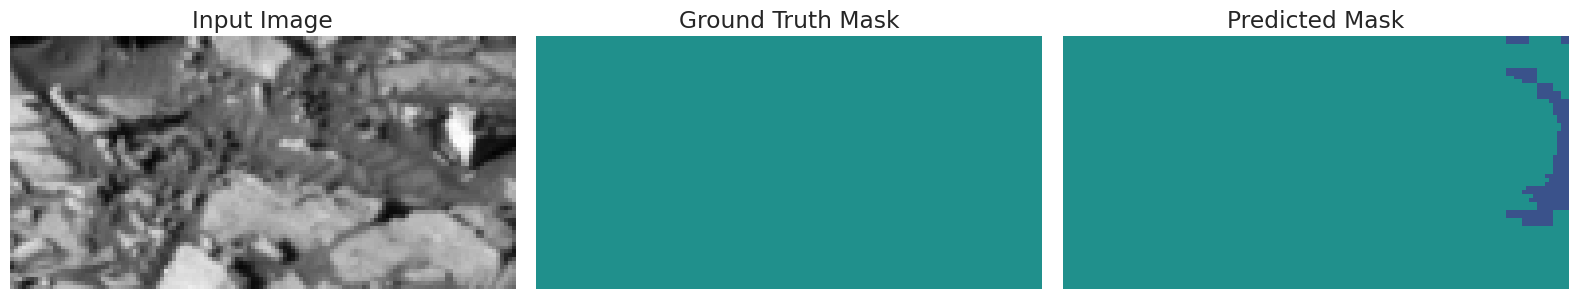

47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 443ms/step - accuracy: 0.6472 - loss: 0.1810 - mean_iou: 0.5716 - val_accuracy: 0.5495 - val_loss: 0.2195 - val_mean_iou: 0.4280 - learning_rate: 5.0000e-04
Epoch 17/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 432ms/step - accuracy: 0.6526 - loss: 0.1780 - mean_iou: 0.5794 - val_accuracy: 0.6014 - val_loss: 0.1992 - val_mean_iou: 0.4922 - learning_rate: 5.0000e-04
Epoch 18/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 431ms/step - accuracy: 0.6578 - loss: 0.1775 - mean_iou: 0.5892 - val_accuracy: 0.5554 - val_loss: 0.2570 - val_mean_iou: 0.4427 - learning_rate: 5.0000e-04
Epoch 19/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 430ms/step - accuracy: 0.6490 - loss: 0.1784 - mean_iou: 0.5733 - val_accuracy: 0.4976 - val_loss: 0.2572 - val_mean_iou: 0.3722 - learning_rate: 5.0000e-04
Epoch 20/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 431ms/step - accuracy: 0.6510 - loss: 0.1788 - mean_iou: 0.5838 - val_accuracy: 0.6418 - val_loss: 0.1878 - val_mean_iou: 0.5452 - learning_rate: 5.0000e-04
Epoch 21

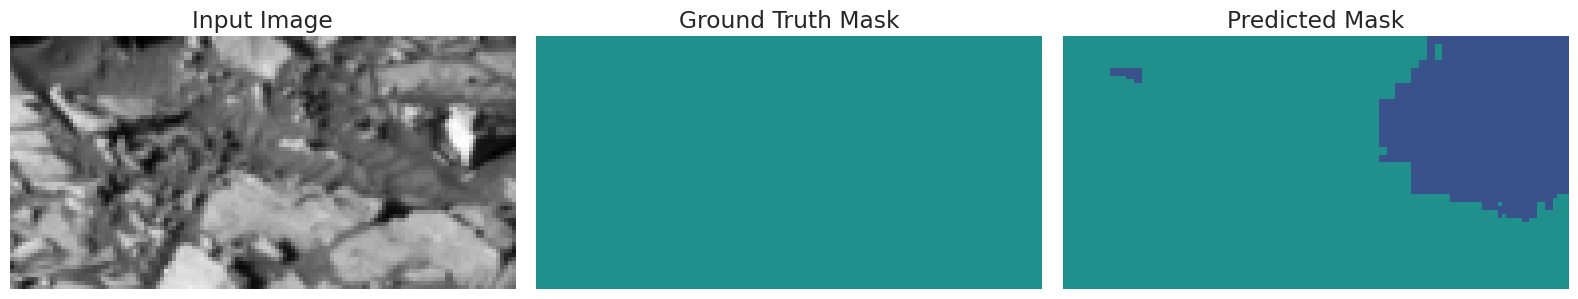

47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 440ms/step - accuracy: 0.6624 - loss: 0.1762 - mean_iou: 0.6119 - val_accuracy: 0.6473 - val_loss: 0.1908 - val_mean_iou: 0.5513 - learning_rate: 5.0000e-04
Epoch 22/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 428ms/step - accuracy: 0.6700 - loss: 0.1741 - mean_iou: 0.6073 - val_accuracy: 0.5558 - val_loss: 0.2313 - val_mean_iou: 0.4420 - learning_rate: 5.0000e-04
Epoch 23/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 429ms/step - accuracy: 0.6660 - loss: 0.1731 - mean_iou: 0.6117 - val_accuracy: 0.5813 - val_loss: 0.2127 - val_mean_iou: 0.4676 - learning_rate: 5.0000e-04
Epoch 24/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 429ms/step - accuracy: 0.6627 - loss: 0.1738 - mean_iou: 0.6328 - val_accuracy: 0.6432 - val_loss: 0.1873 - val_mean_iou: 0.5485 - learning_rate: 5.0000e-04
Epoch 25/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 431ms/step - accuracy: 0.6600 - loss: 0.1750 - mean_iou: 0.6030 - val_accuracy: 0.6484 - val_loss: 0.1851 - val_mean_iou: 0.5547 - learning_rate: 5.0000e-04
Epoch 26

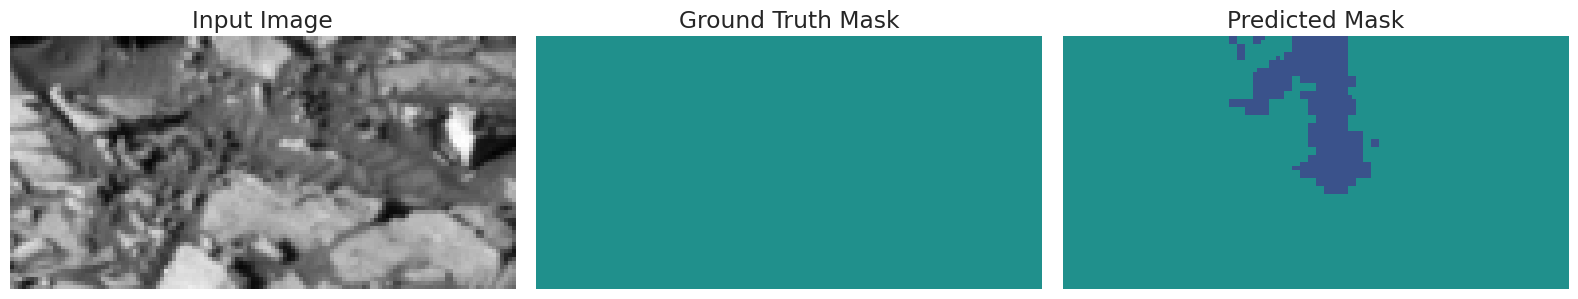

47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 440ms/step - accuracy: 0.6758 - loss: 0.1701 - mean_iou: 0.6643 - val_accuracy: 0.6177 - val_loss: 0.1947 - val_mean_iou: 0.5097 - learning_rate: 5.0000e-04
Epoch 27/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 431ms/step - accuracy: 0.6737 - loss: 0.1694 - mean_iou: 0.6723 - val_accuracy: 0.6680 - val_loss: 0.1844 - val_mean_iou: 0.5826 - learning_rate: 5.0000e-04
Epoch 28/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 430ms/step - accuracy: 0.6750 - loss: 0.1697 - mean_iou: 0.6814 - val_accuracy: 0.6337 - val_loss: 0.1919 - val_mean_iou: 0.5491 - learning_rate: 5.0000e-04
Epoch 29/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 432ms/step - accuracy: 0.6837 - loss: 0.1682 - mean_iou: 0.6813 - val_accuracy: 0.6671 - val_loss: 0.1803 - val_mean_iou: 0.5862 - learning_rate: 5.0000e-04
Epoch 30/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 430ms/step - accuracy: 0.6827 - loss: 0.1677 - mean_iou: 0.6411 - val_accuracy: 0.4645 - val_loss: 0.3014 - val_mean_iou: 0.3448 - learning_rate: 5.0000e-04
Epoch 31

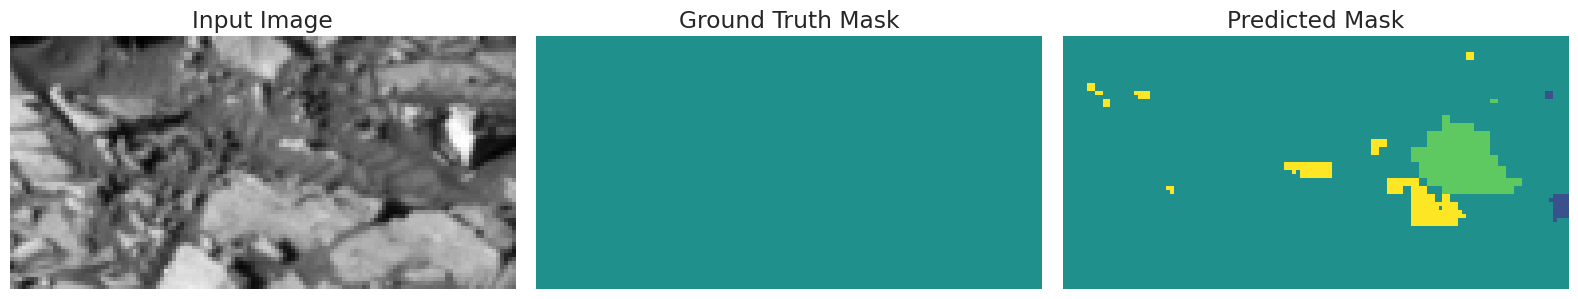

47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 450ms/step - accuracy: 0.6830 - loss: 0.1686 - mean_iou: 0.6471 - val_accuracy: 0.6367 - val_loss: 0.1995 - val_mean_iou: 0.5567 - learning_rate: 5.0000e-04
Epoch 32/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 432ms/step - accuracy: 0.6820 - loss: 0.1670 - mean_iou: 0.7246 - val_accuracy: 0.6799 - val_loss: 0.1880 - val_mean_iou: 0.6194 - learning_rate: 5.0000e-04
Epoch 33/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 430ms/step - accuracy: 0.6888 - loss: 0.1652 - mean_iou: 0.7259 - val_accuracy: 0.6069 - val_loss: 0.2306 - val_mean_iou: 0.5152 - learning_rate: 5.0000e-04
Epoch 34/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.6936 - loss: 0.1645 - mean_iou: 0.7390
Epoch 34: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 431ms/step - accuracy: 0.6939 - loss: 0.1645 - mean_iou: 0.7384 - val_accuracy: 0.6694 - val_loss: 0.1940 - val_mean_iou: 0.5917 - learning_rate: 5.0000e-04
Epoch 35/200
47/47 ━━━━━━━━━━━━━━━━━━━

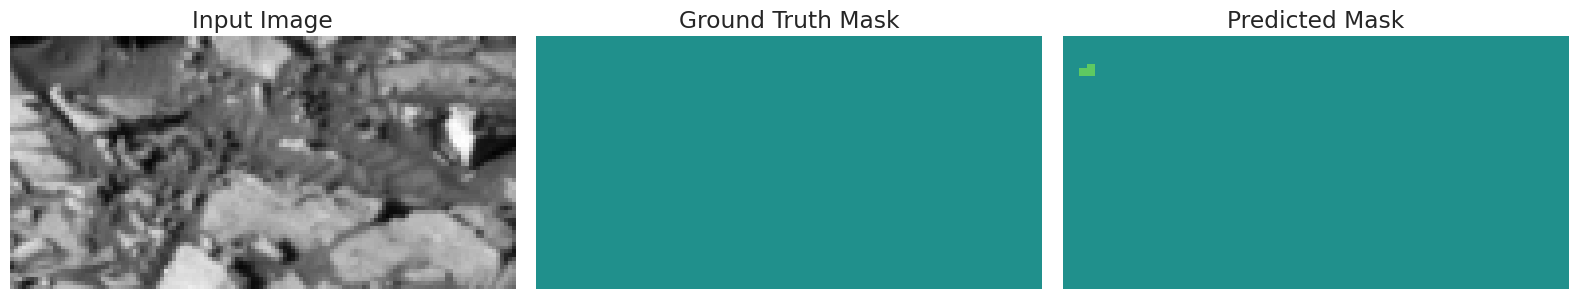

47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 444ms/step - accuracy: 0.7040 - loss: 0.1612 - mean_iou: 0.7510 - val_accuracy: 0.6836 - val_loss: 0.1800 - val_mean_iou: 0.6144 - learning_rate: 2.5000e-04
Epoch 37/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 433ms/step - accuracy: 0.7144 - loss: 0.1579 - mean_iou: 0.8063 - val_accuracy: 0.6850 - val_loss: 0.1863 - val_mean_iou: 0.6203 - learning_rate: 2.5000e-04
Epoch 38/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 431ms/step - accuracy: 0.7196 - loss: 0.1561 - mean_iou: 0.8343 - val_accuracy: 0.6827 - val_loss: 0.1894 - val_mean_iou: 0.6108 - learning_rate: 2.5000e-04
Epoch 39/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 432ms/step - accuracy: 0.7224 - loss: 0.1551 - mean_iou: 0.8369 - val_accuracy: 0.6775 - val_loss: 0.1968 - val_mean_iou: 0.6057 - learning_rate: 2.5000e-04
Epoch 40/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 431ms/step - accuracy: 0.7291 - loss: 0.1532 - mean_iou: 0.8818 - val_accuracy: 0.6743 - val_loss: 0.1976 - val_mean_iou: 0.6033 - learning_rate: 2.5000e-04
Epoch 41

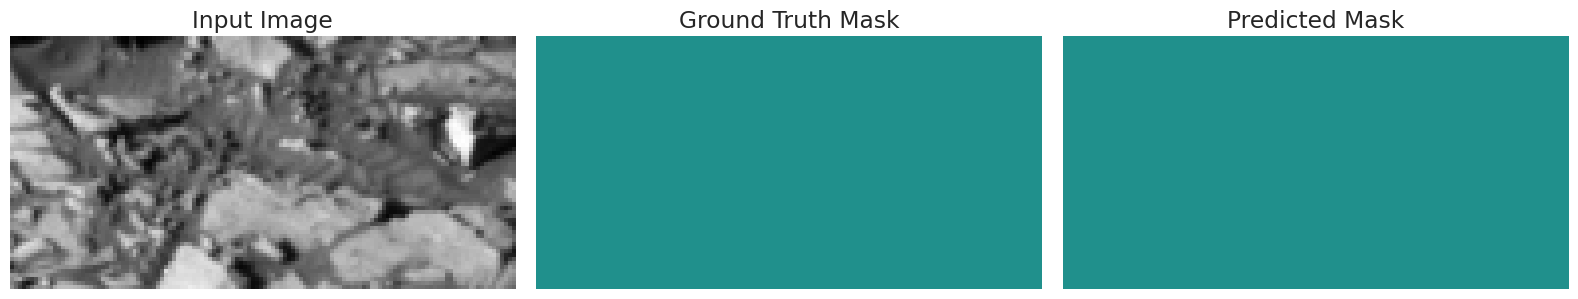

47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 443ms/step - accuracy: 0.7253 - loss: 0.1540 - mean_iou: 0.8492 - val_accuracy: 0.6782 - val_loss: 0.2008 - val_mean_iou: 0.6066 - learning_rate: 2.5000e-04
Epoch 42/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 431ms/step - accuracy: 0.7292 - loss: 0.1526 - mean_iou: 0.8761 - val_accuracy: 0.6842 - val_loss: 0.1948 - val_mean_iou: 0.6121 - learning_rate: 1.2500e-04
Epoch 43/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 432ms/step - accuracy: 0.7344 - loss: 0.1510 - mean_iou: 0.9118 - val_accuracy: 0.6883 - val_loss: 0.1985 - val_mean_iou: 0.6206 - learning_rate: 1.2500e-04
Epoch 44/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 433ms/step - accuracy: 0.7379 - loss: 0.1499 - mean_iou: 0.9353 - val_accuracy: 0.6870 - val_loss: 0.2006 - val_mean_iou: 0.6207 - learning_rate: 1.2500e-04
Epoch 45/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 432ms/step - accuracy: 0.7394 - loss: 0.1491 - mean_iou: 0.9413 - val_accuracy: 0.6868 - val_loss: 0.2062 - val_mean_iou: 0.6190 - learning_rate: 1.2500e-04
Epoch 46

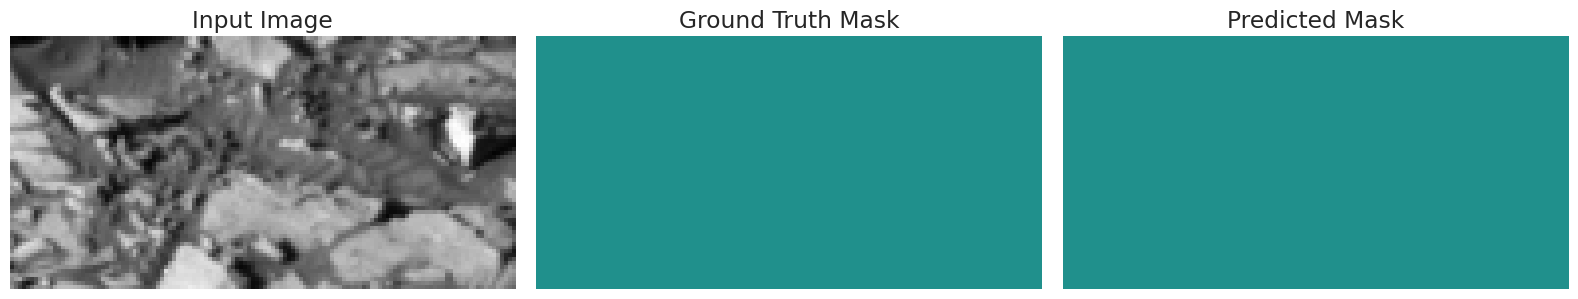

47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 445ms/step - accuracy: 0.7408 - loss: 0.1483 - mean_iou: 0.9474 - val_accuracy: 0.6868 - val_loss: 0.2122 - val_mean_iou: 0.6266 - learning_rate: 1.2500e-04
Epoch 47/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 433ms/step - accuracy: 0.7415 - loss: 0.1480 - mean_iou: 0.9554 - val_accuracy: 0.6890 - val_loss: 0.2060 - val_mean_iou: 0.6311 - learning_rate: 6.2500e-05
Epoch 48/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 433ms/step - accuracy: 0.7427 - loss: 0.1474 - mean_iou: 0.9647 - val_accuracy: 0.6908 - val_loss: 0.2062 - val_mean_iou: 0.6365 - learning_rate: 6.2500e-05
Epoch 49/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 433ms/step - accuracy: 0.7436 - loss: 0.1468 - mean_iou: 0.9677 - val_accuracy: 0.6910 - val_loss: 0.2086 - val_mean_iou: 0.6427 - learning_rate: 6.2500e-05
Epoch 50/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 433ms/step - accuracy: 0.7441 - loss: 0.1463 - mean_iou: 0.9706 - val_accuracy: 0.6914 - val_loss: 0.2167 - val_mean_iou: 0.6439 - learning_rate: 6.2500e-05
Epoch 51

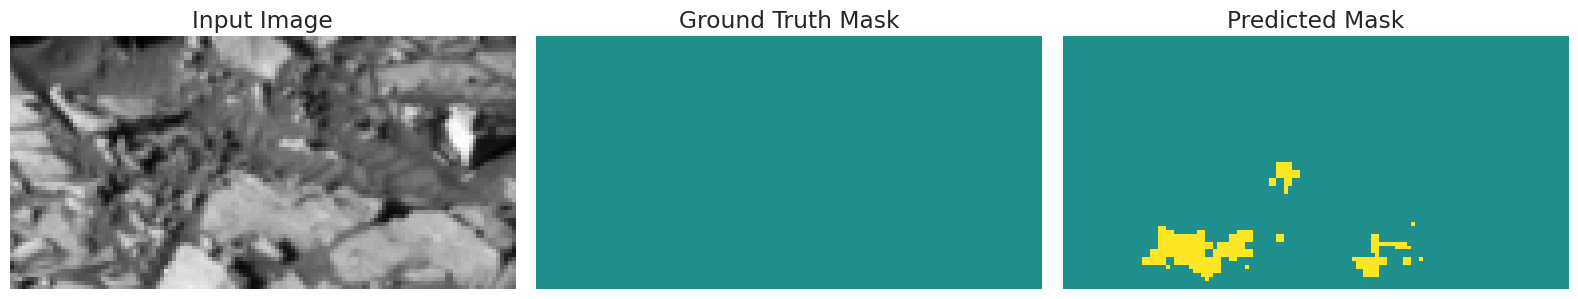

47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 440ms/step - accuracy: 0.7419 - loss: 0.1357 - mean_iou: 0.9033 - val_accuracy: 0.6842 - val_loss: 0.2210 - val_mean_iou: 0.6282 - learning_rate: 6.2500e-05
Epoch 52/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 430ms/step - accuracy: 0.7413 - loss: 0.1272 - mean_iou: 0.8919 - val_accuracy: 0.6884 - val_loss: 0.2173 - val_mean_iou: 0.6376 - learning_rate: 3.1250e-05
Epoch 53/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 432ms/step - accuracy: 0.7428 - loss: 0.1243 - mean_iou: 0.9348 - val_accuracy: 0.6905 - val_loss: 0.2126 - val_mean_iou: 0.6509 - learning_rate: 3.1250e-05
Epoch 54/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 430ms/step - accuracy: 0.7435 - loss: 0.1218 - mean_iou: 0.9260 - val_accuracy: 0.6908 - val_loss: 0.2116 - val_mean_iou: 0.6264 - learning_rate: 3.1250e-05
Epoch 55/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 430ms/step - accuracy: 0.7430 - loss: 0.1174 - mean_iou: 0.8639 - val_accuracy: 0.6867 - val_loss: 0.2168 - val_mean_iou: 0.6162 - learning_rate: 3.1250e-05
Epoch 56

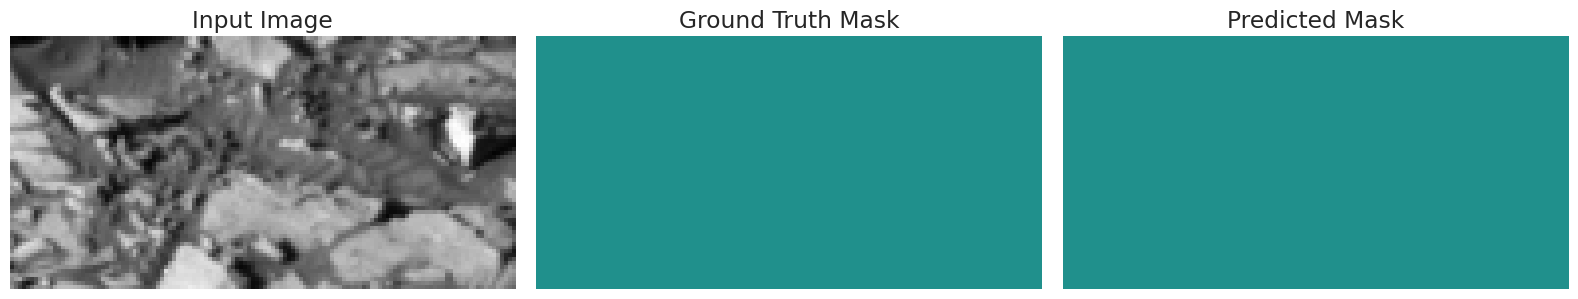

47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 440ms/step - accuracy: 0.7429 - loss: 0.1033 - mean_iou: 0.8302 - val_accuracy: 0.6907 - val_loss: 0.1952 - val_mean_iou: 0.6238 - learning_rate: 3.1250e-05
Epoch 57/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 430ms/step - accuracy: 0.7429 - loss: 0.1015 - mean_iou: 0.7883 - val_accuracy: 0.6928 - val_loss: 0.1943 - val_mean_iou: 0.6257 - learning_rate: 1.5625e-05
Epoch 58/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 429ms/step - accuracy: 0.7440 - loss: 0.0994 - mean_iou: 0.8630 - val_accuracy: 0.6921 - val_loss: 0.1938 - val_mean_iou: 0.6246 - learning_rate: 1.5625e-05
Epoch 59/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 430ms/step - accuracy: 0.7444 - loss: 0.0987 - mean_iou: 0.8960 - val_accuracy: 0.6922 - val_loss: 0.1946 - val_mean_iou: 0.6247 - learning_rate: 1.5625e-05
Epoch 60/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 430ms/step - accuracy: 0.7446 - loss: 0.0983 - mean_iou: 0.9196 - val_accuracy: 0.6914 - val_loss: 0.1957 - val_mean_iou: 0.6237 - learning_rate: 1.5625e-05
Epoch 61

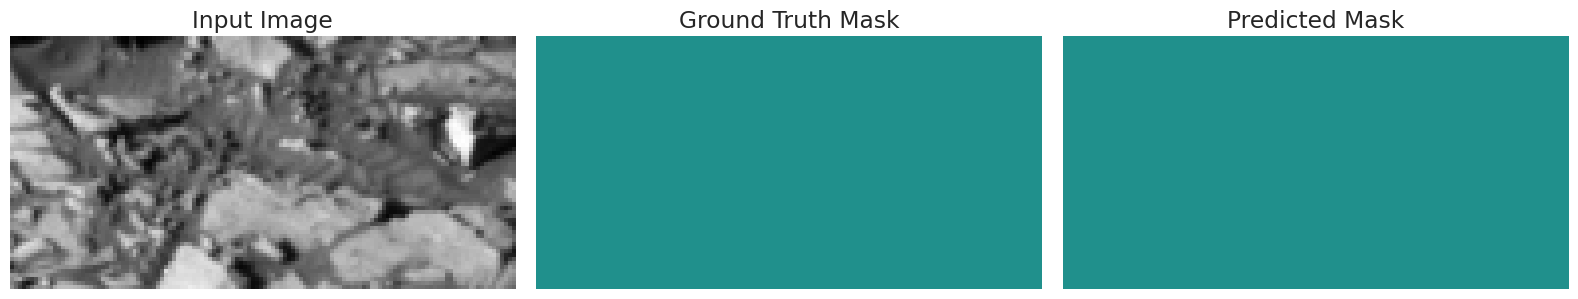

47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 439ms/step - accuracy: 0.7447 - loss: 0.0976 - mean_iou: 0.9365 - val_accuracy: 0.6914 - val_loss: 0.1950 - val_mean_iou: 0.6234 - learning_rate: 1.5625e-05
Epoch 62/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 431ms/step - accuracy: 0.7449 - loss: 0.0975 - mean_iou: 0.9517 - val_accuracy: 0.6903 - val_loss: 0.1972 - val_mean_iou: 0.6216 - learning_rate: 7.8125e-06
Epoch 63/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 431ms/step - accuracy: 0.7450 - loss: 0.0972 - mean_iou: 0.9536 - val_accuracy: 0.6904 - val_loss: 0.1972 - val_mean_iou: 0.6217 - learning_rate: 7.8125e-06
Epoch 64/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 432ms/step - accuracy: 0.7450 - loss: 0.0971 - mean_iou: 0.9581 - val_accuracy: 0.6903 - val_loss: 0.1977 - val_mean_iou: 0.6216 - learning_rate: 7.8125e-06
Epoch 65/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 432ms/step - accuracy: 0.7451 - loss: 0.0971 - mean_iou: 0.9600 - val_accuracy: 0.6903 - val_loss: 0.1982 - val_mean_iou: 0.6215 - learning_rate: 7.8125e-06
Epoch 66

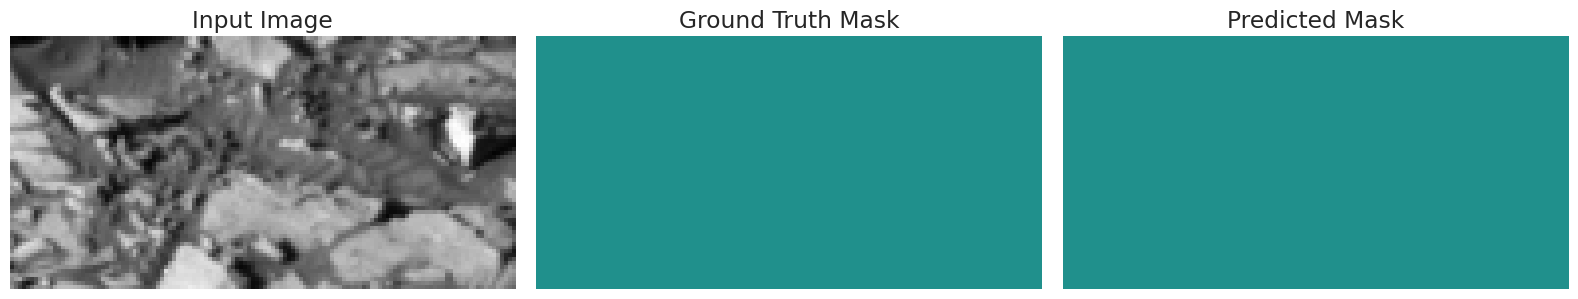

47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 442ms/step - accuracy: 0.7451 - loss: 0.0970 - mean_iou: 0.9610 - val_accuracy: 0.6902 - val_loss: 0.1987 - val_mean_iou: 0.6214 - learning_rate: 7.8125e-06
Epoch 67/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 431ms/step - accuracy: 0.7451 - loss: 0.0969 - mean_iou: 0.9623 - val_accuracy: 0.6902 - val_loss: 0.1991 - val_mean_iou: 0.6214 - learning_rate: 3.9063e-06
Epoch 68/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 431ms/step - accuracy: 0.7451 - loss: 0.0969 - mean_iou: 0.9629 - val_accuracy: 0.6901 - val_loss: 0.1994 - val_mean_iou: 0.6214 - learning_rate: 3.9063e-06
Epoch 69/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 430ms/step - accuracy: 0.7451 - loss: 0.0969 - mean_iou: 0.9635 - val_accuracy: 0.6901 - val_loss: 0.1997 - val_mean_iou: 0.6214 - learning_rate: 3.9063e-06
Epoch 70/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 431ms/step - accuracy: 0.7452 - loss: 0.0969 - mean_iou: 0.9638 - val_accuracy: 0.6901 - val_loss: 0.2000 - val_mean_iou: 0.6213 - learning_rate: 3.9063e-06
Epoch 71

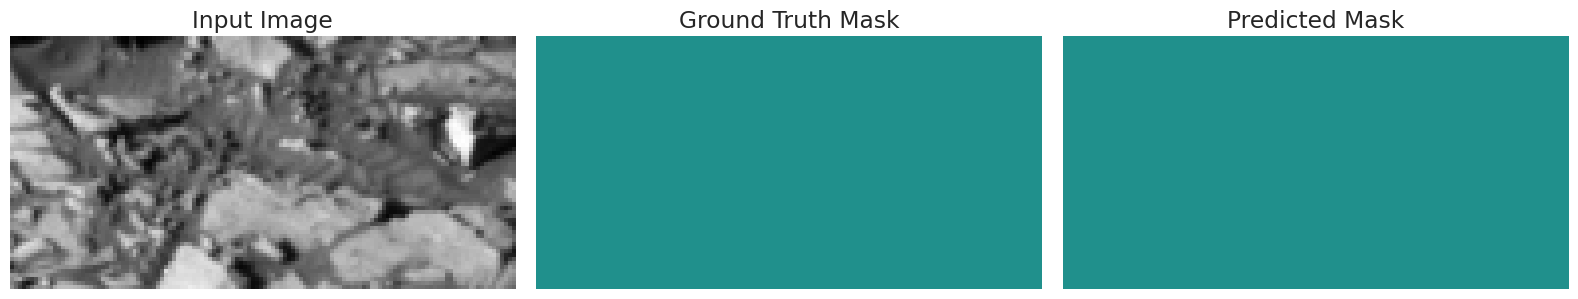

47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 440ms/step - accuracy: 0.7452 - loss: 0.0968 - mean_iou: 0.9640 - val_accuracy: 0.6901 - val_loss: 0.2002 - val_mean_iou: 0.6212 - learning_rate: 3.9063e-06
Epoch 72/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 429ms/step - accuracy: 0.7452 - loss: 0.0968 - mean_iou: 0.9642 - val_accuracy: 0.6900 - val_loss: 0.2005 - val_mean_iou: 0.6212 - learning_rate: 1.9531e-06
Epoch 73/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 431ms/step - accuracy: 0.7452 - loss: 0.0968 - mean_iou: 0.9643 - val_accuracy: 0.6900 - val_loss: 0.2007 - val_mean_iou: 0.6212 - learning_rate: 1.9531e-06


In [15]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr, viz_callback],
    verbose=1
).history

In [16]:
# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'UNet_2_'+str(final_val_meanIoU)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Final validation Mean Intersection Over Union: 65.09%


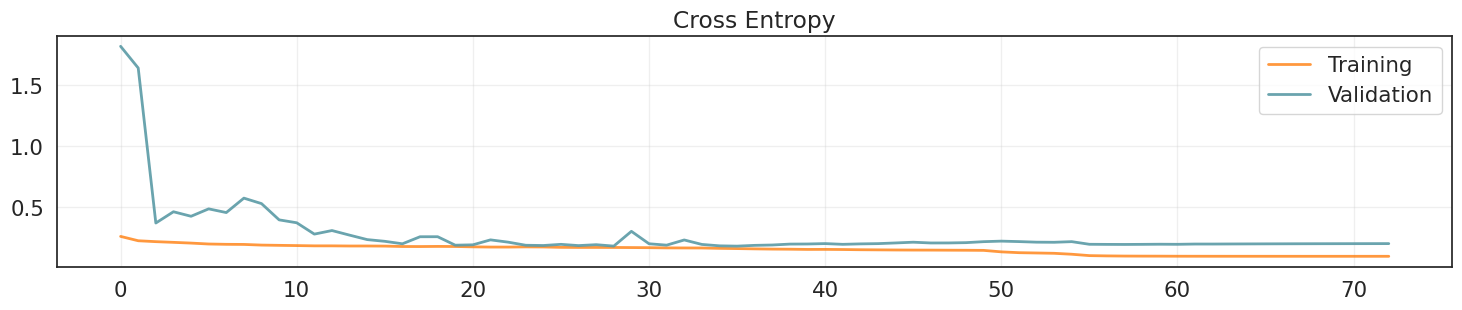

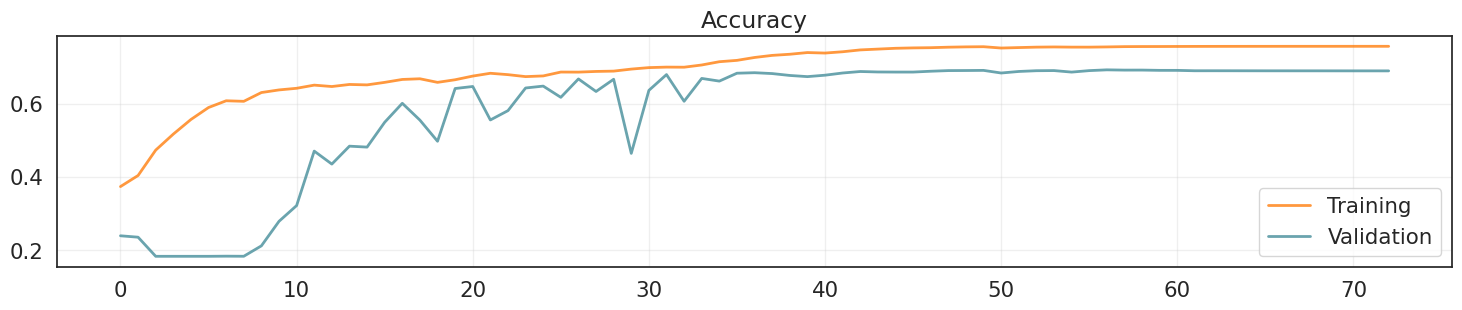

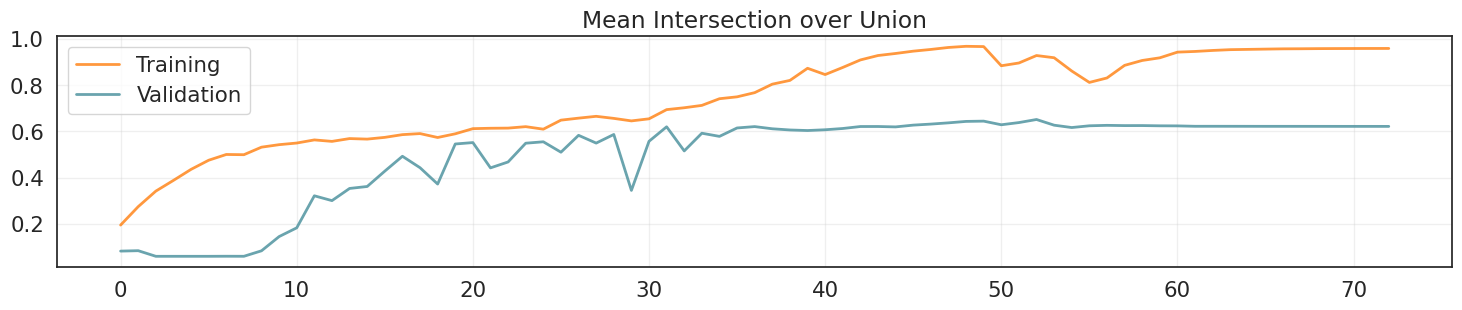

In [17]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 🕹️ Use the Model - Make Inference

In [19]:
# path
model_path = "/kaggle/working/UNet_2_65.09.keras"

# Load the model
model = tf.keras.models.load_model(model_path, compile=False)
print("Model loaded successfully.")

Model loaded successfully.


In [20]:
model.compile(optimizer="adam",
              loss=lambda y_true, y_pred: combined_loss(y_true, y_pred, dice_weight=0.2, focal_weight=0.8),
              metrics=["accuracy",
                       MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])])


In [21]:
test_loss, test_accuracy, test_mean_iou = model.evaluate(X_our_test, y_our_test, verbose=1)
print(f"Loss: {test_loss}\nAccuracy: {test_accuracy}\nMean Over Union: {test_mean_iou}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 308ms/step - accuracy: 0.6660 - loss: 0.2190 - mean_iou: 0.6335
Loss: 0.20888091623783112
Accuracy: 0.6793714761734009
Mean Over Union: 0.6579825282096863


In [22]:
def calculate_class_iou(y_true, y_pred, num_classes):
    class_iou = {}

    for class_idx in range(num_classes):
        # Crea una maschera binaria per la classe
        true_mask = (y_true == class_idx).astype(int)
        pred_mask = (y_pred == class_idx).astype(int)

        # Calcola l'intersezione e l'unione
        intersection = np.logical_and(true_mask, pred_mask).sum()
        union = np.logical_or(true_mask, pred_mask).sum()

        # Calcola IoU, evitando la divisione per zero
        iou = intersection / union if union > 0 else 0.0
        class_iou[class_idx] = iou

    return class_iou

In [23]:
# Compute the prediction
y_pred = model.predict(X_our_test, batch_size=10)
y_pred_labels = tf.math.argmax(y_pred, axis=-1).numpy()

# Compute IoU per class
iou_per_class = calculate_class_iou(y_our_test, y_pred_labels, num_classes)

# Print the results
for class_idx, iou in iou_per_class.items():
    print(f"Class {class_idx}: IoU = {round(iou, 4)}")

51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step
Class 0: IoU = 0.0
Class 1: IoU = 0.726
Class 2: IoU = 0.5436
Class 3: IoU = 0.6531
Class 4: IoU = 0.0364


In [24]:
def calculate_metrics_per_class(y_true, y_pred, num_classes):
    metrics = {}

    for class_idx in range(num_classes):
        # Create binary masks for the current class
        true_binary = (y_true == class_idx).flatten()
        pred_binary = (y_pred == class_idx).flatten()

        # Compute precision, recall, and F1-score
        precision = precision_score(true_binary, pred_binary, zero_division=0)
        recall = recall_score(true_binary, pred_binary, zero_division=0)
        f1 = f1_score(true_binary, pred_binary, zero_division=0)

        # Store the metrics for the current class
        metrics[class_idx] = {
            "Precision": precision,
            "Recall": recall,
            "F1-score": f1
        }

    return metrics

In [25]:
# Compute metrics for each class
metrics_per_class = calculate_metrics_per_class(y_our_test, y_pred_labels, num_classes)

# Print the results for each class
for class_idx, metrics in metrics_per_class.items():
    print(f"Class {class_idx}:")
    print(f"  Precision = {round(metrics['Precision'], 4)}")
    print(f"  Recall = {round(metrics['Recall'], 4)}")
    print(f"  F1-score = {round(metrics['F1-score'], 4)}")

Class 0:
  Precision = 0.0
  Recall = 0.0
  F1-score = 0.0
Class 1:
  Precision = 0.7835
  Recall = 0.9083
  F1-score = 0.8413
Class 2:
  Precision = 0.574
  Recall = 0.9111
  F1-score = 0.7043
Class 3:
  Precision = 0.692
  Recall = 0.9207
  F1-score = 0.7901
Class 4:
  Precision = 0.0446
  Recall = 0.165
  F1-score = 0.0702


## 📊 Prepare Your Submission


In [26]:
# Percorso del file del modello
model_path = "/kaggle/working/UNet_2_65.09.keras"

# Carica il modello
model = tf.keras.models.load_model(model_path, compile=False)
print("Model loaded successfully.")

Model loaded successfully.


In [27]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 48s 146ms/step
Predictions shape: (10022, 64, 128)


In [28]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [29]:
# Create and save the CSV submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)  # Convert predictions to DataFrame
submission_df.to_csv(f"/kaggle/working/{submission_filename}", index=False)

print(f"Submission file saved: {submission_filename}")

Submission file saved: submission_UNet_2_65.09.csv
